# CAD CAFEH manhattan plots

We ran CAFEH with gene expression from GTEx and CAD GWAS (from where?)

- Gather each suggestive hit in the GWAS (p<1e-6)
- Find all genes within 1Mb window of that hit with an eQTL
- Run CAD x GTEx for each gene
    - using variants within 1Mb of the genes TSS
    - variants in GTEx mapped to rsids
    - kept intersection of rsids from GTEx and CAD gwas
    - only kept variants with fully observed summary stats (test reported in each expressed tissue)
    

hits reported at `output/CAD/CAD/CAD.hits.txt`

gene tissue pairs for inclusion at `output/CAD/CAD/CAD.hits.txt`

saved model paths at `output/CAD/CAD/CAD.z.css.requests.txt`



generate any of these files with `snakemake {path} -j1`

to run CAFEH execute `python batched_job.py output/CAD/CAD/CAD.z.css.requests.txt 50 10:0:0`

When I run it, 30 models are not fit due to no intersection of rsids between GTEx and CAD gwas

## Known coloc examples

These are genes known to colocalize with CAD (from Marios)
Here we generate figures for these known genes

In [1]:
import json
import numpy as np
import pandas as pd
import pysam
import pickle
import sys
sys.path.append('../workflow/scripts/')
from ukbb_gtex_cafeh_ss import load_gtex_associations, load_cad_gwas, load_gtex_genotype
from cafeh.model_queries import summary_table, coloc_table

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle


gc26 = pd.read_csv(
    '../output/annotations/gencode/gencode.v26.annotation.gene.txt', sep='\t')

genename2geneid = gc26.set_index('gene_name').gene_id.to_dict()

known_coloc_gene_names = [
    'SORT1', 'LMOD1', 'ABCG8', 'PHACTR1', 'TCF21',
    'TWIST1', 'LPL', 'ARHGAP42', 'CETP', 'APOE',
    'ANGPTL4', 'LDLR', 'PLPP3', 'CDKN2B', 'GUCY1A3', 'LPA'
]
[genename2geneid.get(g) for g in known_coloc_gene_names]

def donate_column(_df, donor_df, donor_column, matching_columns, default):
    df = _df.copy()
    donor_dict = donor_df.set_index(matching_columns).loc[:, donor_column].to_dict()
    df.loc[:, donor_column] = [donor_dict.get(rec, default)
                               for rec in zip(*[df.loc[:, c]for c in matching_columns])]
    return df

In [2]:
%%time
gene = genename2geneid.get('LPL')

def load_model(gene):
    # load model
    gc26 = pd.read_csv(
        '../output/annotations/gencode/gencode.v26.annotation.gene.txt', sep='\t')
    p = '../output/CAD/CAD/{chrom}/{gene}/{gene}.CAD.z.css'.format(
        chrom=gc26.set_index('gene_id').loc[gene].chr,
        gene=gene
    )
    model = pickle.load(open(p, 'rb'))
    model._decompress_model()
    return model

def make_cafeh_manhattan_df(gene):
    model = load_model(gene)

    # load summary stats
    gtex = load_gtex_associations(gene, rel='../')
    cad = load_cad_gwas(gene, rel='../')

    # filter down to snps included in model
    cad = cad[cad.rsid.isin(model.snp_ids)]
    gtex = gtex[gtex.rsid.isin(model.snp_ids)]
    df = pd.concat([gtex, cad])

    # get bp position for rsids from gtex
    df.loc[:, 'nl10p'] = -np.log10(df.pval_nominal)
    df = df.rename(columns={'tissue': 'study'})

    ct = coloc_table(model, 'CAD')
    ct = ct.rename(columns={'tissue': 'study', 'top_component': 'component'})

    # make table
    table = summary_table(model, filter_variants=False)
    table = table.rename(columns={'variant_id': 'rsid', 'top_component': 'component'})
    table = donate_column(table, df, 'nl10p', ['study', 'rsid'], 0)
    table = donate_column(table, ct, 'p_coloc', ['study', 'component'], 0)
    
    rsid2pos = {rs: int(v.split('_')[1]) for rs, v in zip(gtex.rsid, gtex.variant_id)}
    table.loc[:, 'pos'] = table.rsid.apply(lambda x: rsid2pos.get(x))
    table.loc[:, 'coloc_with'] = 'CAD'
    return table

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [3]:
def make_cafeh_manhattan_plot(_df, studies=None, alpha=0.99, col_wrap=3, coloc_t=0.9, active_t=0.9):
    """
    studies: list of studies
    alpha: credible set size
    """
    if studies is None:
        studies = _df[_df.p_coloc > coloc_t].study.unique()
    df = _df[_df.study.isin(studies)]

    df.loc[:, 'active_component'] = (df.component + 1) * (df.alpha < alpha) * (df.p_active > active_t) - 1
    df.loc[:, 'marker_size'] = (df.active_component.values >= 0) * 100 + 1
    
    component2marker = df.groupby('component').apply(lambda x: x[x.p_coloc > coloc_t].study.unique().size >= 2)
    
    df.loc[:, 'marker'] = df.component.apply(lambda x: component2marker.get(x))
    

    hue_order = np.sort(df.active_component.unique())
    palette = [(0, 0, 0)] + sns.color_palette("hls", hue_order.size - 1)
    
    
    sns.set_context("paper", rc={"font.size":12,"axes.titlesize":20,"axes.labelsize":16})   

    g = sns.relplot(
        data=df[df.study.isin(studies)],
        x="pos", y="nl10p",
        hue="active_component", size='marker_size', style='marker',
        col="study", col_wrap=col_wrap,
        hue_order=hue_order,
        palette=palette,
        sizes=(20, 200),
        edgecolor=None,
        facet_kws=dict(sharey=False),
        style_order=[True, False], markers=['*', '.'],
        legend=False
    )
    g.set_titles(col_template = '{col_name}')
    g.set_axis_labels( "Position" , "-log10(p)") 

    
    # custom legend
    active_components = np.array(hue_order[1:])
    colors = np.array(palette[1:])
    coloc = component2marker[active_components].values
    
    legend_patches = []
    
    if coloc.sum() > 0:
        legend_patches.append(Rectangle((0,0), 0, 0, color='w', label='Colocalizing with CAD'))
        legend_patches.extend([
            Line2D([], [], label=k, linestyle='None', marker='*',
                   color=color, markerfacecolor=color, markersize=10)
            for k, color in zip(active_components[coloc], colors[coloc]) 
        ])
    if np.any(~coloc):
        legend_patches.append(Rectangle((0,0), 0, 0, color='w', label='Not colocalizing with CAD'))
        legend_patches.extend([
            Line2D([], [], label=k, linestyle='None', marker='.',
                   color=color, markerfacecolor=color, markersize=10)
            for k, color in zip(active_components[~coloc], colors[~coloc]) 
        ])
    # Plot the legend
    g.fig.get_axes()[np.min([col_wrap, len(studies)]) - 1].legend(
        handles=legend_patches,
        title = '{}% CAFEH Credible SNPs'.format(int(alpha*100)),
        bbox_to_anchor=(1.01, 1),borderaxespad=0
    )
    
    #g.legend(legend_elements)
    #g._legend.legendHandles = legend_elements
    return g

### ARGHAP42

range:  chr11 99558384.0 101862668.0


/home-3/ktayeb1@jhu.edu/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
/home-3/ktayeb1@jhu.edu/.local/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home-3/ktayeb1@jhu.edu/.local/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


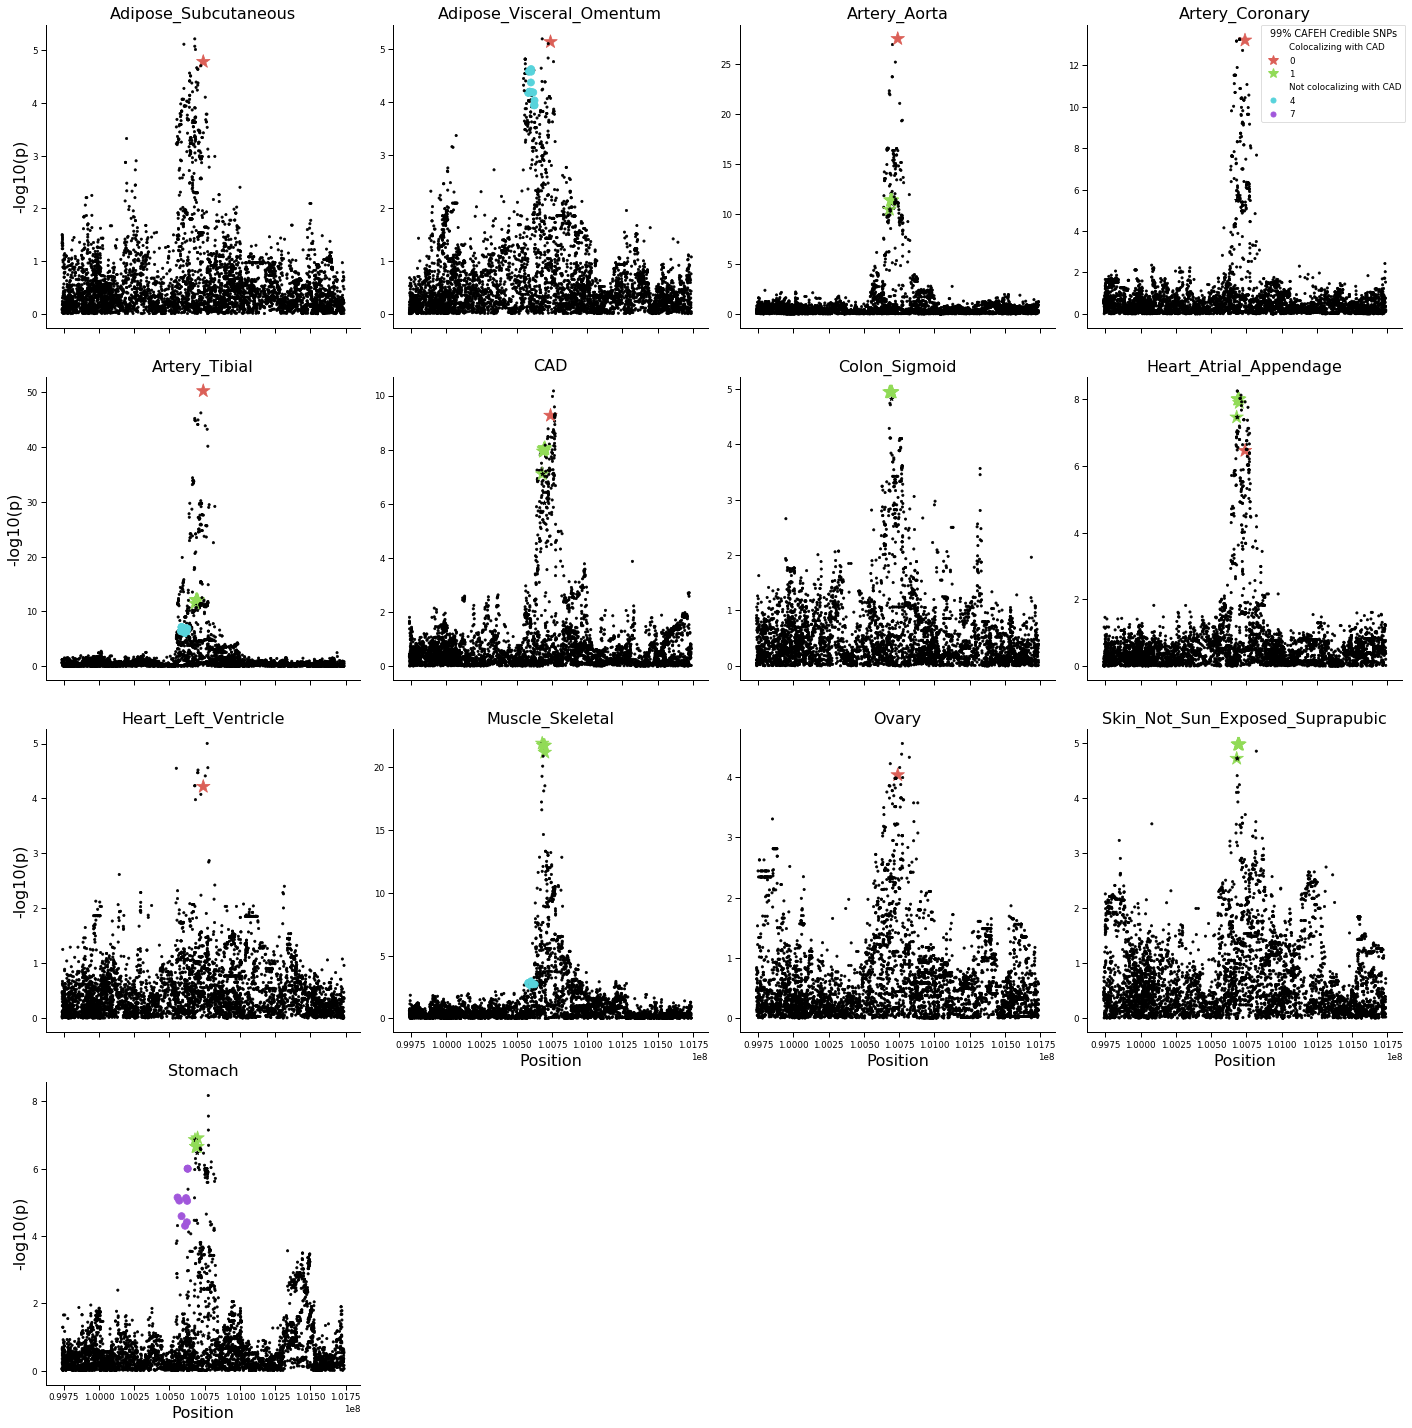

In [4]:
df = make_cafeh_manhattan_df(genename2geneid.get('ARHGAP42'))
g = make_cafeh_manhattan_plot(df, col_wrap=4)

### SMAD3

range:  chr15 66356101.0 68487533.0


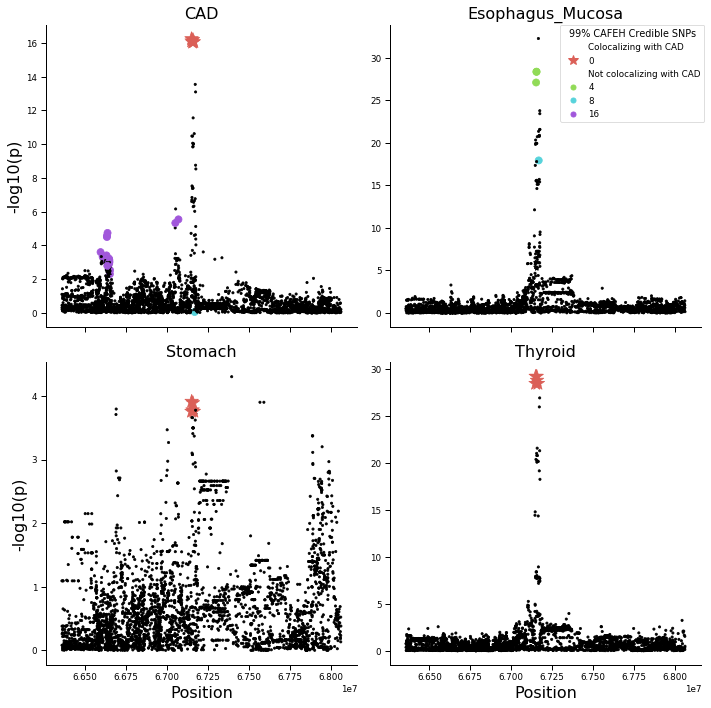

In [5]:
df = make_cafeh_manhattan_df(genename2geneid.get('SMAD3'))
g = make_cafeh_manhattan_plot(df, col_wrap=2)

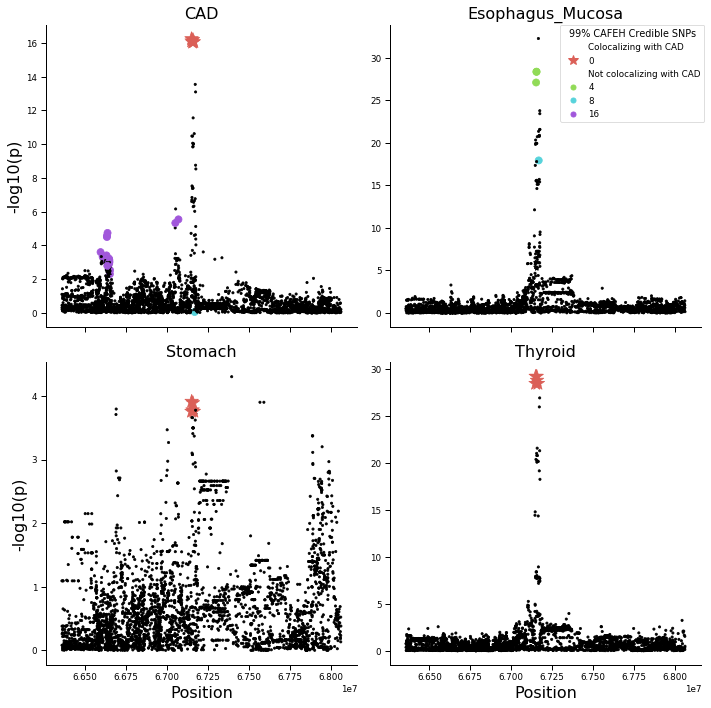

In [6]:
g = make_cafeh_manhattan_plot(df, col_wrap=2)

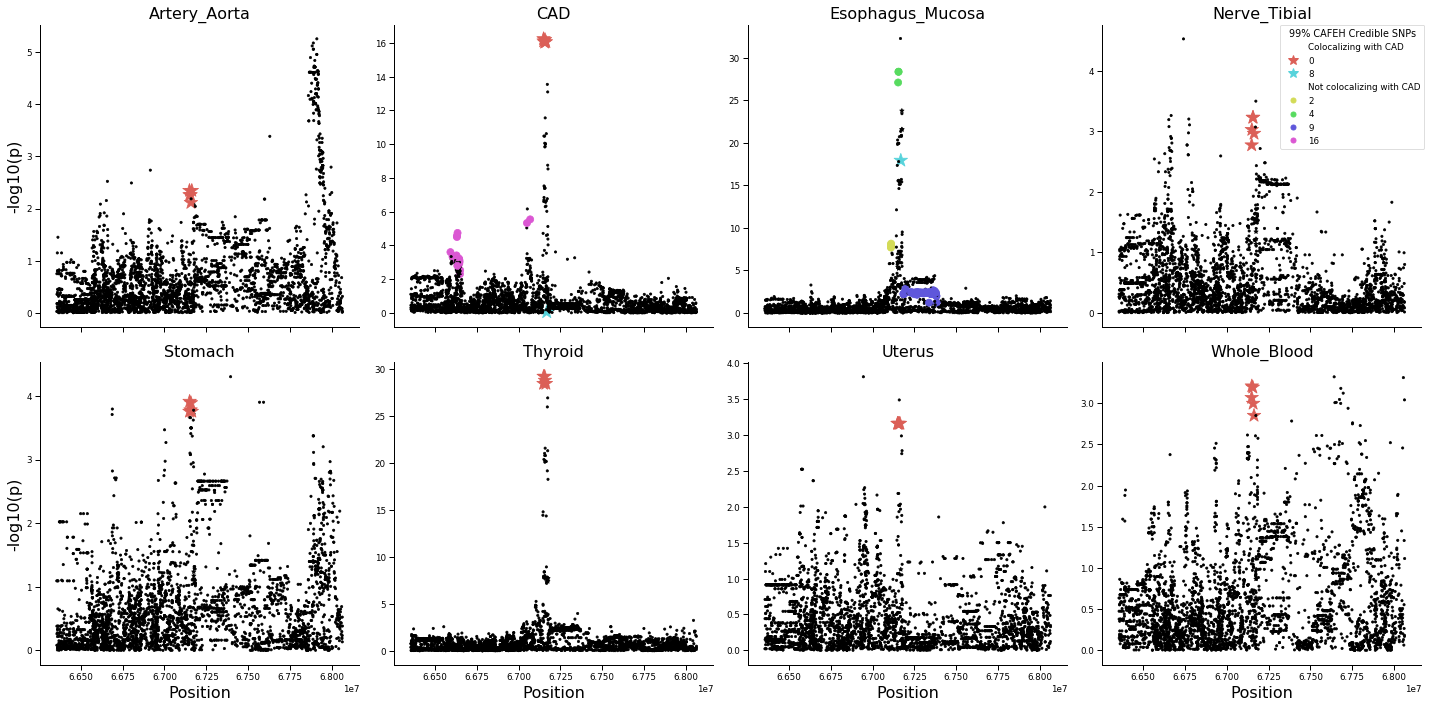

In [7]:
g = make_cafeh_manhattan_plot(df, col_wrap=4, coloc_t=0.5, active_t=0.5)

### TWIST1

range:  chr7 18060614.0 20157295.0


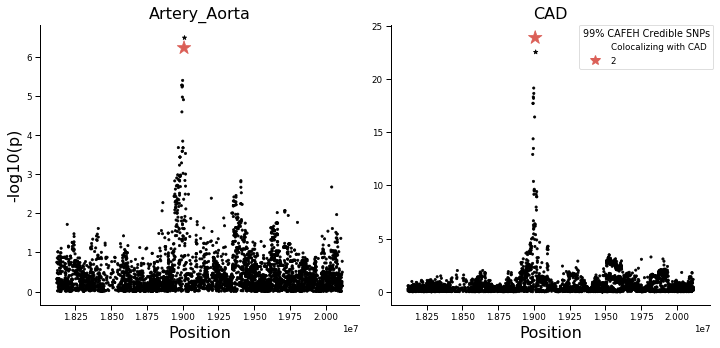

In [8]:
df = make_cafeh_manhattan_df(genename2geneid.get('TWIST1'))
g = make_cafeh_manhattan_plot(df)

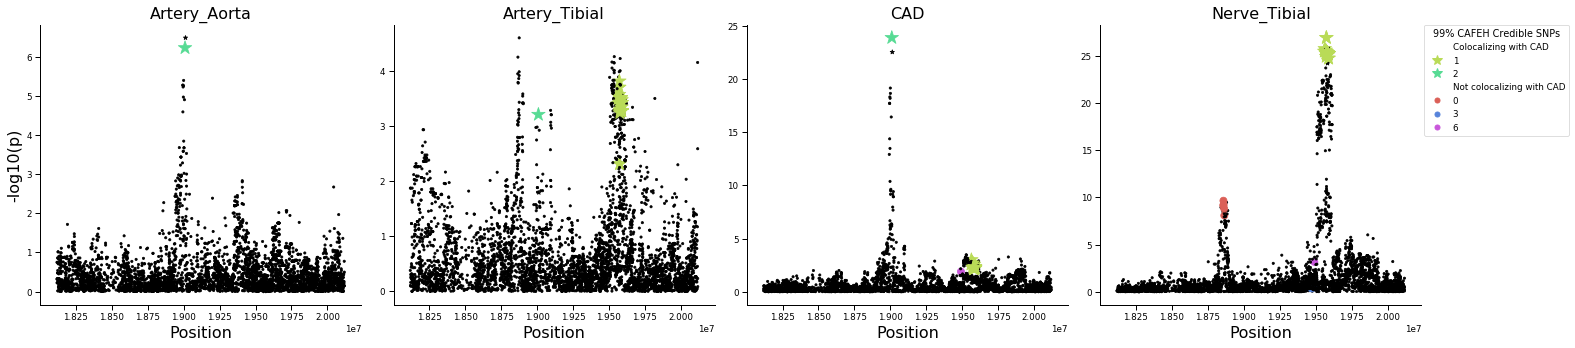

In [9]:
g = make_cafeh_manhattan_plot(df, col_wrap=4, coloc_t=0.5, active_t=0.5)

In [10]:
studies = df.groupby('study').p_active.max()
studies = studies[studies > 0.5].index.values

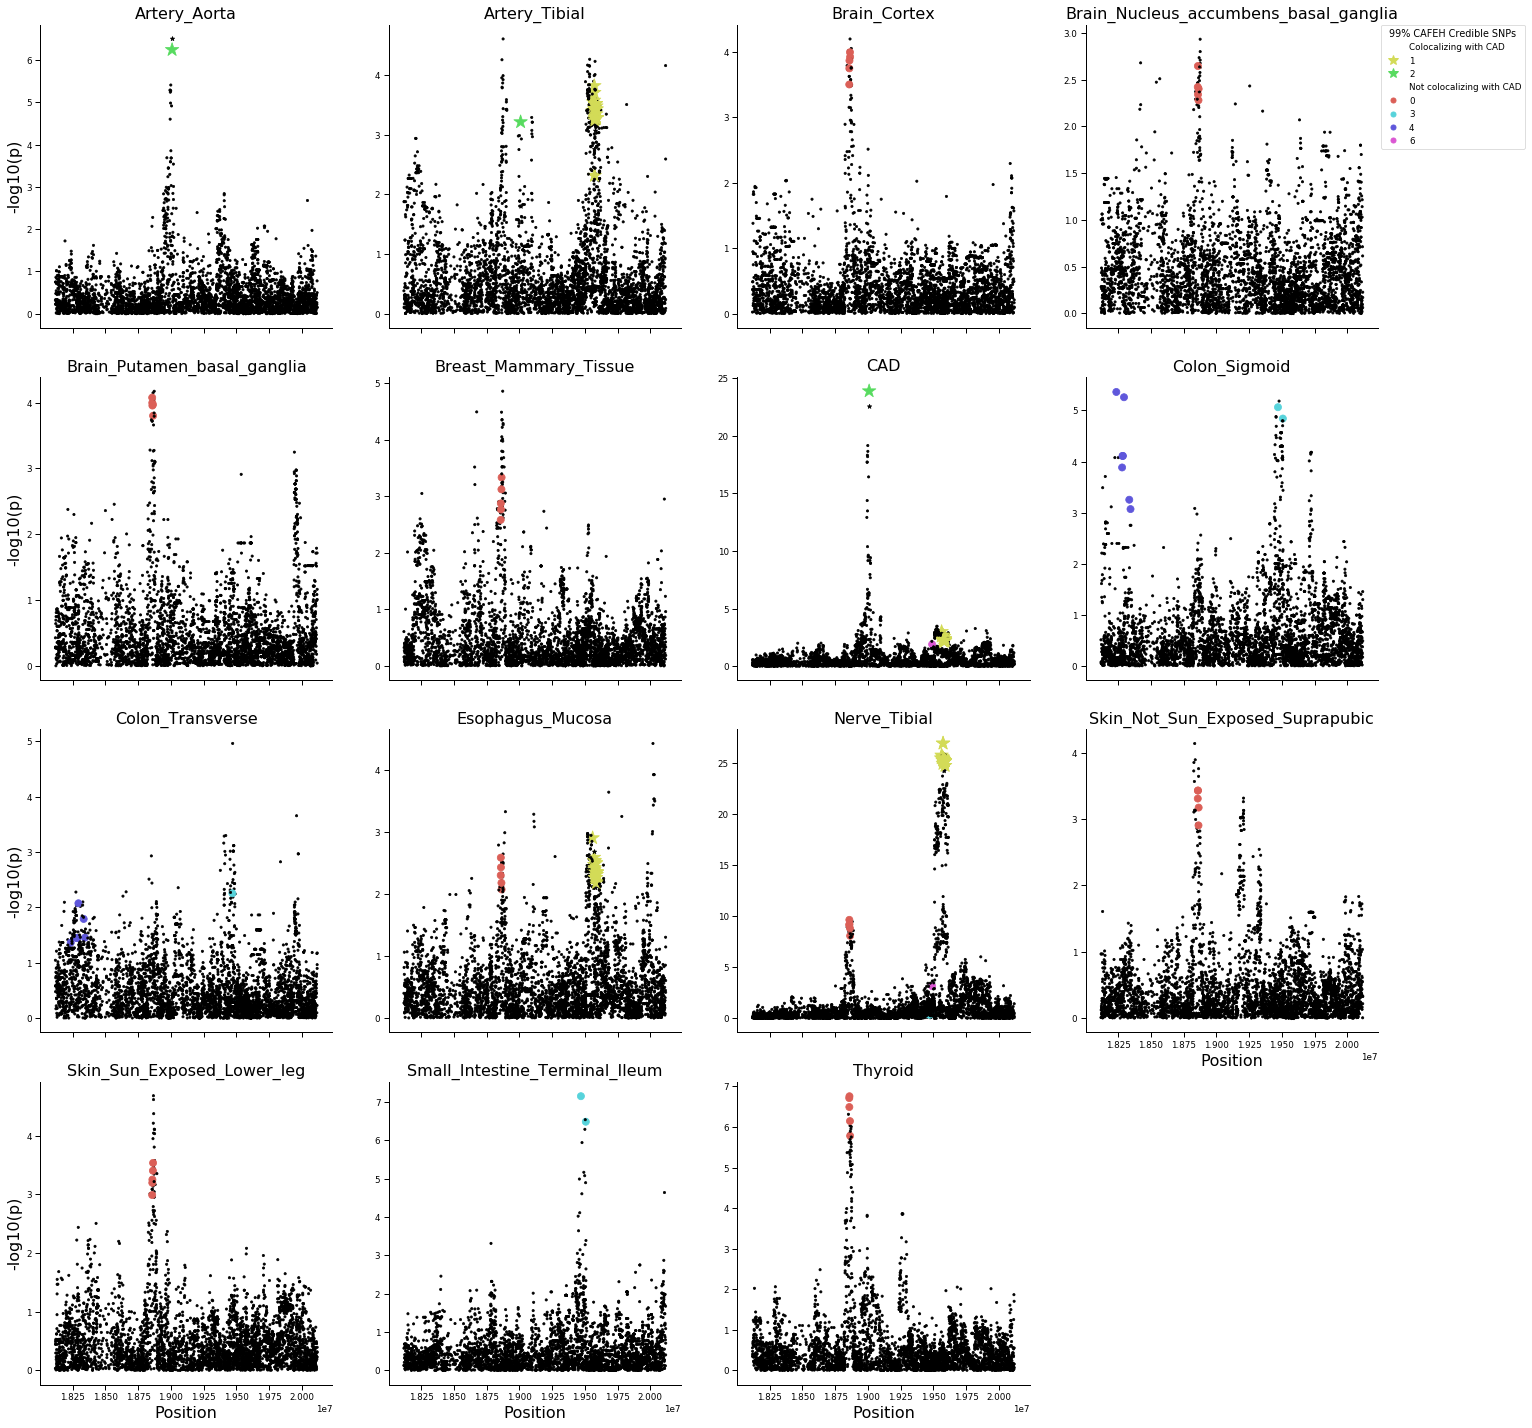

In [11]:
g = make_cafeh_manhattan_plot(df, studies=studies, col_wrap=4, coloc_t=0.5, active_t=0.5)

In [ ]:
g = make_cafeh_manhattan_plot(df, studies=df.study.unique(), col_wrap=5, coloc_t=0.5, active_t=0.5)

In [ ]:
m = load_model(genename2geneid.get('TWIST1'))
pd.DataFrame(m.active, index=m.study_ids).max(1).sort_values()

### GUCY1A3

In [ ]:
df[df.study == ]

In [ ]:
df.study.unique()

In [ ]:
df = make_cafeh_manhattan_df(genename2geneid.get('GUCY1A3'))
g = make_cafeh_manhattan_plot(
    df,
    studies = ['CAD', 'Artery_Aorta', 'Artery_Coronary', 'Artery_Tibial'],
    coloc_t=0.5, active_t=0.5
)

In [ ]:
a = df[df.study.isin(
    ['CAD']) & (df.alpha<0.99) & df.component.isin([0, 1, 6])]#.rsid.unique()

genotype = load_gtex_genotype(genename2geneid.get('GUCY1A3'), use_rsid=True)

sns.heatmap(genotype.loc[:, a.sort_values(['component']).rsid.values].corr()**2, square=True)